In [1]:
!git clone https://github.com/facebookresearch/dino.git
%cd dino

# Install requirements
!pip install -r requirements.txt
!pip install torchvision torch

Cloning into 'dino'...
remote: Enumerating objects: 175, done.
remote: Total 175 (delta 0), reused 0 (delta 0), pack-reused 175 (from 1)
Receiving objects: 100% (175/175), 24.47 MiB | 38.08 MiB/s, done.
Resolving deltas: 100% (100/100), done.
/kaggle/working/dino
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.3 MB/s eta 0:00:00:00:0100:01

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import time
from torch.utils.data import random_split, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLIENTS = 100
C = 0.1
PARTICIPATING_CLIENTS = int(NUM_CLIENTS * C)
NUM_ROUNDS = 100
LOCAL_EPOCHS = 4
BATCH_SIZE = 32

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                              download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                             download=True, transform=transform)

train_set, val_set = random_split(train_dataset, [40000, 10000])
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

def split_dataset(dataset, num_clients):
    size_per_client = len(dataset) // num_clients
    return random_split(dataset, [size_per_client]*num_clients)

client_datasets = split_dataset(train_set, NUM_CLIENTS)
client_loaders = [DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True) for ds in client_datasets]

100%|██████████| 169M/169M [00:05<00:00, 29.6MB/s] 


In [3]:
import vision_transformer as vits

def get_fresh_model():
    model = vits.__dict__['vit_small'](patch_size=16)
    state_dict = torch.hub.load_state_dict_from_url(
        "https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth",
        map_location=device
    )
    model.load_state_dict(state_dict, strict=True)
    classifier = nn.Linear(model.embed_dim, 100)
    return model.to(device), classifier.to(device)

global_model, global_classifier = get_fresh_model()

Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_deitsmall16_pretrain.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 175MB/s] 


In [4]:
def train_local(model, classifier, dataloader, epochs, device):
    model.train()
    classifier.train()
    optimizer = torch.optim.SGD(
        list(model.parameters()) + list(classifier.parameters()),
        lr=0.001, momentum=0.9
    )
    criterion = nn.CrossEntropyLoss()
    for _ in range(epochs):
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            features = model(images)
            if isinstance(features, dict) and 'x_norm_clstoken' in features:
                features = features['x_norm_clstoken']
            elif features.ndim == 3:
                features = features[:, 0, :]
            outputs = classifier(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    return model.state_dict(), classifier.state_dict()

def average_weights(weight_list):
    avg = weight_list[0].copy()
    for key in avg:
        for i in range(1, len(weight_list)):
            avg[key] += weight_list[i][key]
        avg[key] = avg[key] / len(weight_list)
    return avg

def evaluate(model, classifier, loader):
    model.eval()
    classifier.eval()
    correct, total = 0, 0
    total_loss = 0.0
    criterion = nn.CrossEntropyLoss(reduction='sum')
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            feats = model(images)
            if isinstance(feats, dict) and 'x_norm_clstoken' in feats:
                feats = feats['x_norm_clstoken']
            elif feats.ndim == 3:
                feats = feats[:, 0, :]
            preds = classifier(feats)
            loss = criterion(preds, labels)
            total_loss += loss.item()
            _, predicted = torch.max(preds, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    acc = 100 * correct / total
    avg_loss = total_loss / total
    return acc, avg_loss

In [5]:
import random
import time
import csv
import copy

val_accuracies = []
val_losses = []
start_time = time.time()

for round_idx in range(NUM_ROUNDS):
    print(f"--- Round {round_idx + 1} ---")
    local_model_weights, local_clf_weights = [], []

    selected_clients_indices = random.sample(range(NUM_CLIENTS), PARTICIPATING_CLIENTS)

    for i in selected_clients_indices:
        client_model = copy.deepcopy(global_model)
        client_clf = copy.deepcopy(global_classifier)
        mw, cw = train_local(
            client_model, client_clf, client_loaders[i],
            LOCAL_EPOCHS, device
        )
        local_model_weights.append(mw)
        local_clf_weights.append(cw)
        del client_model, client_clf
        torch.cuda.empty_cache()

    global_model.load_state_dict(average_weights(local_model_weights))
    global_classifier.load_state_dict(average_weights(local_clf_weights))

    acc, loss = evaluate(global_model, global_classifier, val_loader)
    val_accuracies.append(acc)
    val_losses.append(loss)
    print(f"Validation Accuracy: {acc:.2f}%, Validation Loss: {loss:.4f}")

print("\nFederated IID Training Complete!")
print(f"Total training time: {(time.time() - start_time)/60:.2f} minutes")

test_acc, test_loss = evaluate(global_model, global_classifier, test_loader)
print(f"Final Test Accuracy: {test_acc:.2f}%")
print(f"Final Test Loss: {test_loss:.4f}")

--- Round 1 ---
Validation Accuracy: 1.27%, Validation Loss: 5.2789
--- Round 2 ---
Validation Accuracy: 4.02%, Validation Loss: 4.4927
--- Round 3 ---
Validation Accuracy: 4.61%, Validation Loss: 4.3715
--- Round 4 ---
Validation Accuracy: 5.60%, Validation Loss: 4.2760
--- Round 5 ---
Validation Accuracy: 6.11%, Validation Loss: 4.2088
--- Round 6 ---
Validation Accuracy: 7.44%, Validation Loss: 4.1363
--- Round 7 ---
Validation Accuracy: 8.16%, Validation Loss: 4.0589
--- Round 8 ---
Validation Accuracy: 9.95%, Validation Loss: 3.9864
--- Round 9 ---
Validation Accuracy: 10.04%, Validation Loss: 3.9624
--- Round 10 ---
Validation Accuracy: 10.69%, Validation Loss: 3.9203
--- Round 11 ---
Validation Accuracy: 11.27%, Validation Loss: 3.8914
--- Round 12 ---
Validation Accuracy: 11.54%, Validation Loss: 3.8790
--- Round 13 ---
Validation Accuracy: 12.59%, Validation Loss: 3.8397
--- Round 14 ---
Validation Accuracy: 12.80%, Validation Loss: 3.8436
--- Round 15 ---
Validation Accuracy:

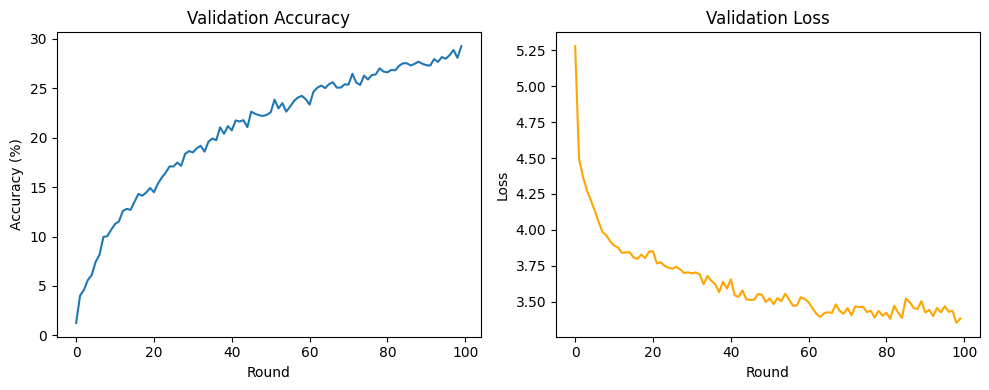

In [6]:
import json
import os

EXPERIMENT_NAME = "iid_j4X"
SAVE_DIR = "results_j4X"
os.makedirs(SAVE_DIR, exist_ok=True)


with open(f"{SAVE_DIR}/val_accuracy_{EXPERIMENT_NAME}.json", "w") as f:
    json.dump(val_accuracies, f)

with open(f"{SAVE_DIR}/val_loss_{EXPERIMENT_NAME}.json", "w") as f:
    json.dump(val_losses, f)

with open(f"{SAVE_DIR}/final_test_accuracy_{EXPERIMENT_NAME}.txt", "w") as f:
    f.write(str(test_acc))

with open(f"{SAVE_DIR}/final_test_loss_{EXPERIMENT_NAME}.txt", "w") as f:
    f.write(str(test_loss))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Round")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(val_losses, label="Val Loss", color="orange")
plt.xlabel("Round")
plt.ylabel("Loss")
plt.title("Validation Loss")

plt.tight_layout()
plt.savefig(f"{SAVE_DIR}/val_accuracy_loss_plot_{EXPERIMENT_NAME}.png")
plt.show()

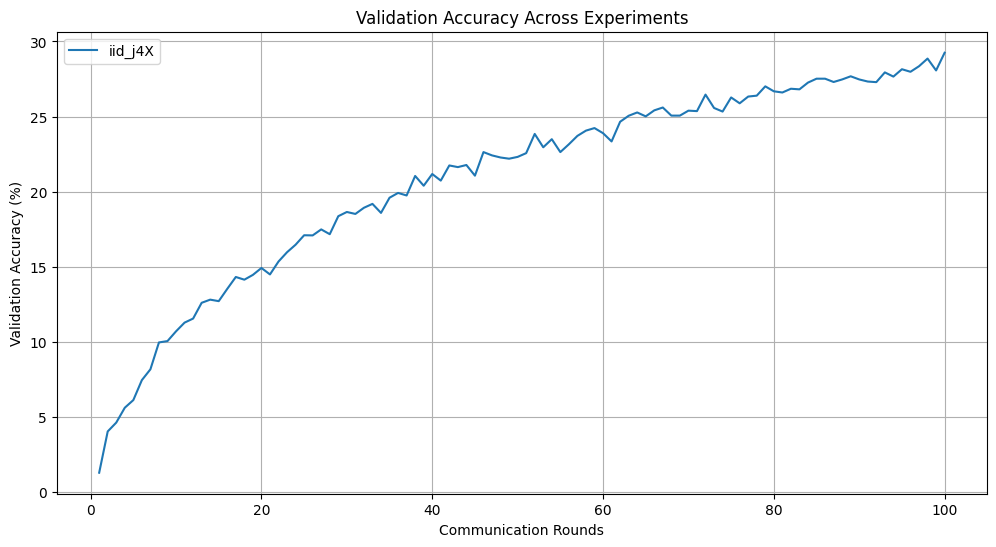


=== Final Test Accuracy Summary ===
iid_j4X: 29.25%


In [7]:
import os
import json
import matplotlib.pyplot as plt

result_dir = "results_j4X"
val_accuracies_dict = {}
test_accuracies_dict = {}

for fname in os.listdir(result_dir):
    if fname.startswith("val_accuracy") and fname.endswith(".json"):
        label = fname.replace("val_accuracy_", "").replace(".json", "")
        with open(os.path.join(result_dir, fname), "r") as f:
            val_accuracies_dict[label] = json.load(f)
    if fname.startswith("final_test_accuracy") and fname.endswith(".txt"):
        label = fname.replace("final_test_accuracy_", "").replace(".txt", "")
        with open(os.path.join(result_dir, fname), "r") as f:
            test_accuracies_dict[label] = float(f.read().strip())

plt.figure(figsize=(12, 6))
for label, accs in val_accuracies_dict.items():
    plt.plot(range(1, len(accs)+1), accs, label=label)
plt.xlabel("Communication Rounds")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy Across Experiments")
plt.legend()
plt.grid(True)
plt.savefig("results_j4X/comparison_plot.png")
plt.show()

print("\n=== Final Test Accuracy Summary ===")
for label, acc in sorted(test_accuracies_dict.items()):
    print(f"{label}: {acc:.2f}%")

In [8]:
import shutil

shutil.make_archive('/kaggle/working/dino/results_j4X', 'zip', 'results_j4X')

'/kaggle/working/dino/results_j4X.zip'

In [9]:
with open("results_j4X.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Round", "Validation Accuracy"])
    for i, acc in enumerate(val_accuracies, start=1):
        writer.writerow([i, acc])

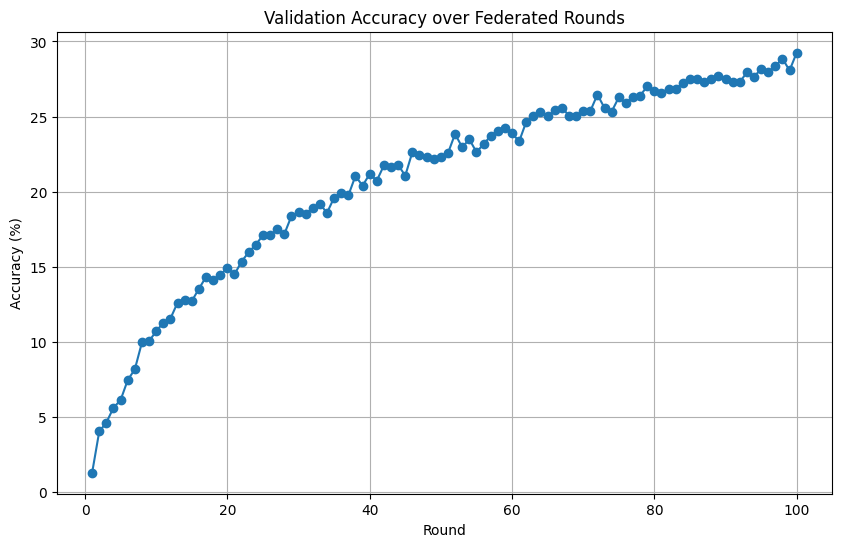

In [10]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, NUM_ROUNDS+1), val_accuracies, marker='o')
plt.title("Validation Accuracy over Federated Rounds")
plt.xlabel("Round")
plt.ylabel("Accuracy (%)")
plt.grid(True)
plt.savefig("val_accuracy_curve.png")
plt.show()

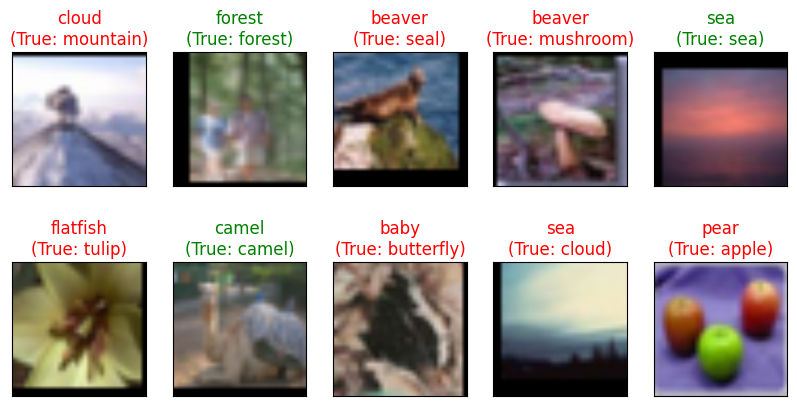

In [11]:
import matplotlib.pyplot as plt
import numpy as np

classes = train_dataset.classes

global_model.eval()
global_classifier.eval()

dataiter = iter(test_loader)
images, labels = next(dataiter)

images, labels = images.to(device), labels.to(device)
features = global_model(images)
outputs = global_classifier(features)
_, predicted = torch.max(outputs, 1)

fig = plt.figure(figsize=(10, 5))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    img = images[idx].cpu().numpy().transpose((1, 2, 0))
    img = np.clip((img * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406], 0, 1)
    plt.imshow(img)
    ax.set_title(f"{classes[predicted[idx]]}\n(True: {classes[labels[idx]]})",
                 color=("green" if predicted[idx]==labels[idx] else "red"))
plt.show()